In [6]:
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt  # viz
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer  # векторизация текстов
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF  # dimred
import re
import pandas as pd
import warnings

In [7]:
warnings.filterwarnings("ignore")

data = pd.read_csv("literature.csv")
data = data.values.tolist() # превращаем в список 
data = [''.join(x) for x in data]
n_samples = len(data)  # размер корпуса
n_features = 1000  # максимальное количество слов в матрице "слово x документ" (= top1000 частотных их всех в корпусе)
n_components = 10  # число тем в корпусе
n_top_words = 20  # порог частотности для визуализаций

In [8]:

stop_words = set(stopwords.words("russian"))
lemmatizer = WordNetLemmatizer()
morph = MorphAnalyzer()

def lemmatize(text):
    words = text.split() # разбиваем текст на слова
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)

    return res

In [10]:
for i in range(len(data) - 1):  # предобработка текста
    data[i] = data[i].replace(u'\xa0', u' ')
    data[i] = data[i].lower()
    data[i] = re.sub(r'\d+', '', data[i])
    translator = str.maketrans('', '', string.punctuation)
    data[i] = data[i].translate(translator)
    data[i] = " ".join(data[i].split())
    word_tokens = word_tokenize(data[i])
    data[i] = [word for word in word_tokens if word not in stop_words]
    data[i] = ' '.join(data[i])
    data[i] = lemmatize(data[i])
    data[i] = ' '.join(data[i])


print("Количество документов ", len(data))
print(data[0])


Количество документов  180
сначала граф лев николаевич толстой отказаться курение алкоголь мясо момент год толстой отказаться слуга стать одеваться убираться свой комната трудный признаваться выносить мыть свой ночной горшок стать ежедневно выносить мыть свой горшок принципиально софья андреевич жена писать дневник « лёвочка жить барин свой имение робинзона крузый необитаемый остров возить дом вода рубить дрова ходить крестьянский рубаха опростился… » это « опрощение » толстой произойти просто конец х — начало х год написание больший роман « война мир » « анна каренин » толстой пережить глубокий духовный кризис прежний жизнь семья литературный славой опротиветь потерять смысл задумываться самоубийство выйти кризис решить стать новый человек решить покончить прежний барство жить жить миллион простой человек зарабатывать жизнь свой труд увидеть ранний окружать новый глаз — увидеть неприличный количество слуга дом сколько вокруг ненужный дорога вещь стать угнетать мысль комфорт праздность

In [11]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,  # игнорируем слова,которые только в 1 доке или в 95% документов.
                                max_features=n_features,
                                stop_words='english')

tf = tf_vectorizer.fit_transform(data)

print(tf.shape)  # матрица "слова x документы"

print(tf_vectorizer.get_feature_names()[996:1000])

(180, 1000)
['являться', 'язык', 'языковой', 'яркий']


In [12]:

lda = LatentDirichletAllocation(n_components=n_components, max_iter=20, learning_offset=50)

lda.fit(tf)

print(lda.components_.shape)

(10, 1000)


In [13]:

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15))  # параметры отображения
    axes = axes.flatten()
    all_features = {}  # словарь для сохранения ключевых слов для тем

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        # строка для сохранения темы и слов в словарь

        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.show()

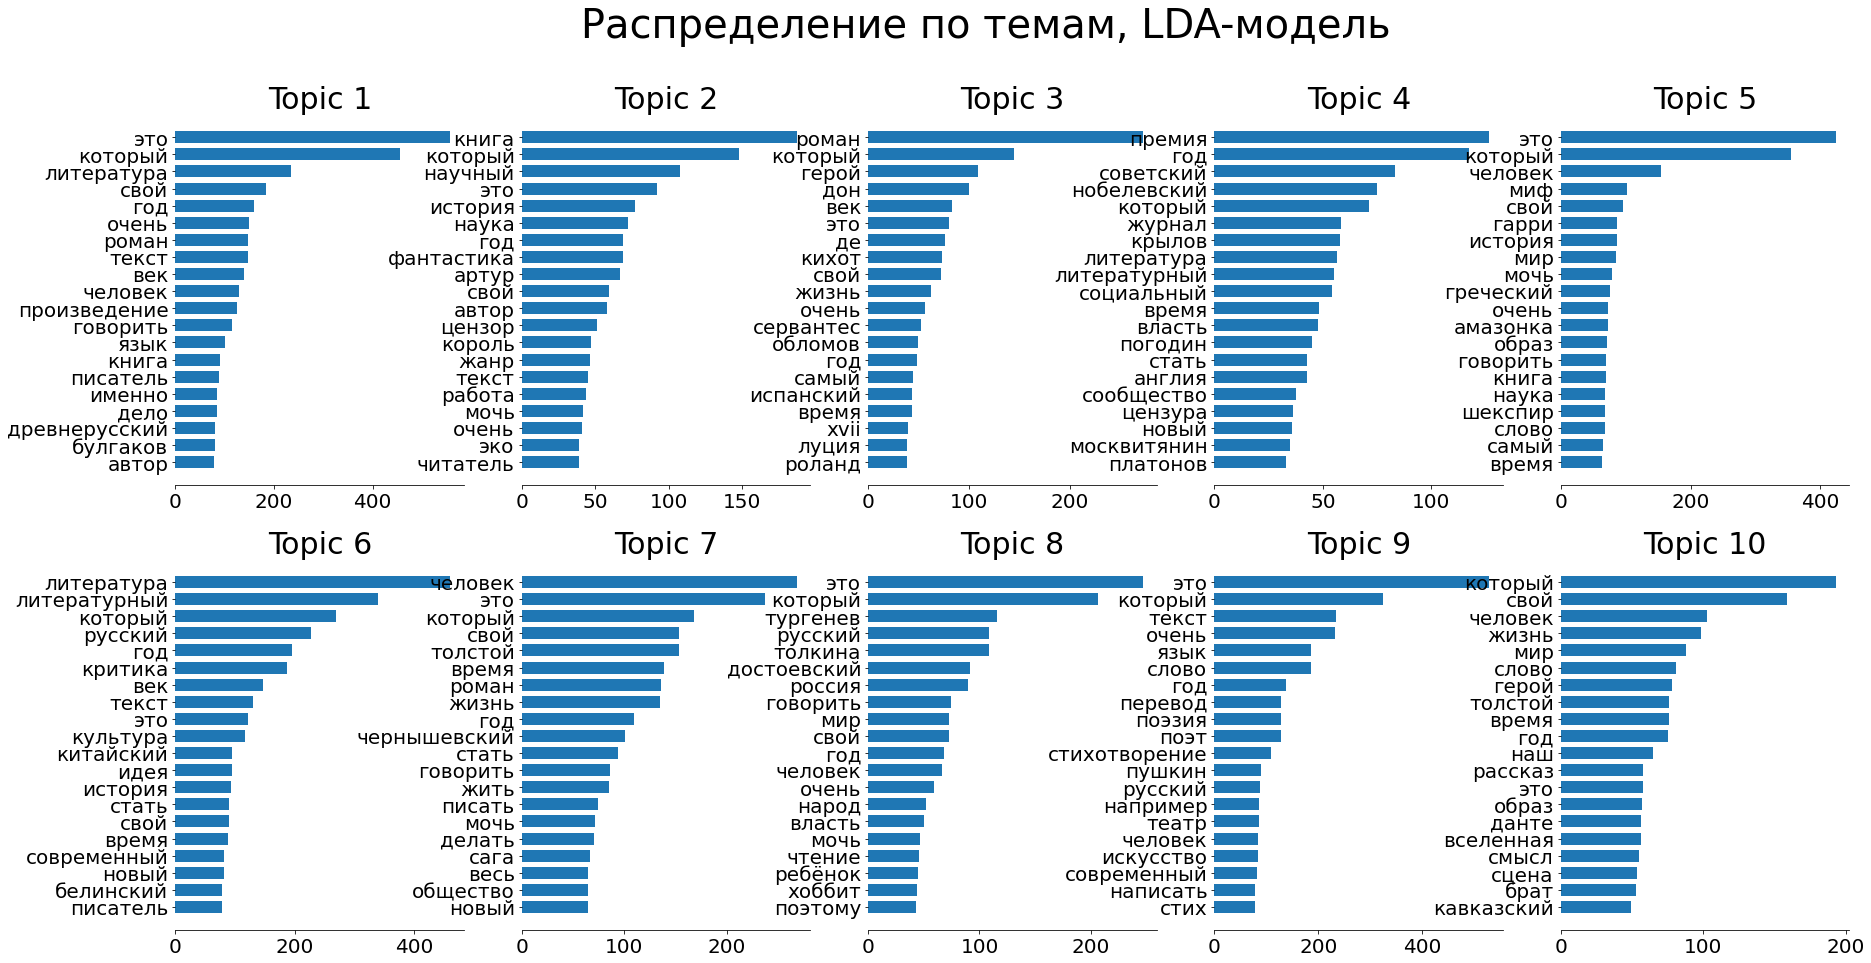

In [14]:

tf_feature_names = tf_vectorizer.get_feature_names()

plot_top_words(lda, tf_feature_names, n_top_words, 'Распределение по темам, LDA-модель')



In [15]:
def print_top_words(model, feature_names, n_top_words):
    all_features = {}

    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))


print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
это который литература свой год очень роман текст век человек произведение говорить язык книга писатель именно дело древнерусский булгаков автор
Topic #1:
книга который научный это история наука год фантастика артур свой автор цензор король жанр текст работа мочь очень эко читатель
Topic #2:
роман который герой дон век это де кихот свой жизнь очень сервантес обломов год самый испанский время xvii луция роланд
Topic #3:
премия год советский нобелевский который журнал крылов литература литературный социальный время власть погодин стать англия сообщество цензура новый москвитянин платонов
Topic #4:
это который человек миф свой гарри история мир мочь греческий очень амазонка образ говорить книга наука шекспир слово самый время
Topic #5:
литература литературный который русский год критика век текст это культура китайский идея история стать свой время современный новый белинский писатель
Topic #6:
человек это который свой толстой время роман жизнь год чернышевский стать говорить жи

In [16]:
doc_topic = lda.transform(tf)

for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax() + 1
    print("doc: {} topic: {}\n".format(n, topic_most_pr))

doc: 0 topic: 7

doc: 1 topic: 8

doc: 2 topic: 7

doc: 3 topic: 2

doc: 4 topic: 4

doc: 5 topic: 5

doc: 6 topic: 5

doc: 7 topic: 8

doc: 8 topic: 7

doc: 9 topic: 8

doc: 10 topic: 7

doc: 11 topic: 7

doc: 12 topic: 6

doc: 13 topic: 9

doc: 14 topic: 10

doc: 15 topic: 9

doc: 16 topic: 4

doc: 17 topic: 6

doc: 18 topic: 2

doc: 19 topic: 2

doc: 20 topic: 10

doc: 21 topic: 7

doc: 22 topic: 7

doc: 23 topic: 5

doc: 24 topic: 3

doc: 25 topic: 6

doc: 26 topic: 3

doc: 27 topic: 8

doc: 28 topic: 8

doc: 29 topic: 3

doc: 30 topic: 8

doc: 31 topic: 5

doc: 32 topic: 8

doc: 33 topic: 3

doc: 34 topic: 7

doc: 35 topic: 4

doc: 36 topic: 2

doc: 37 topic: 5

doc: 38 topic: 6

doc: 39 topic: 3

doc: 40 topic: 6

doc: 41 topic: 5

doc: 42 topic: 4

doc: 43 topic: 7

doc: 44 topic: 6

doc: 45 topic: 1

doc: 46 topic: 7

doc: 47 topic: 10

doc: 48 topic: 4

doc: 49 topic: 7

doc: 50 topic: 6

doc: 51 topic: 7

doc: 52 topic: 10

doc: 53 topic: 9

doc: 54 topic: 7

doc: 55 topic: 6

In [17]:
print(doc_topic)

[[1.64511964e-04 1.64503273e-04 1.64502311e-04 ... 1.64512420e-04
  1.64508922e-04 1.64516022e-04]
 [1.52479144e-04 1.52470945e-04 1.52477055e-04 ... 9.98627698e-01
  1.52481640e-04 1.52477297e-04]
 [1.73056670e-04 1.73051796e-04 1.73052041e-04 ... 2.96751700e-01
  5.34307089e-02 1.73051822e-04]
 ...
 [3.65736658e-02 3.98528734e-01 1.21532413e-04 ... 1.21538055e-04
  2.06046575e-01 1.21541796e-04]
 [2.29423765e-04 3.18463630e-01 2.29411300e-04 ... 2.29420690e-04
  1.61330782e-01 3.23147513e-01]
 [5.26481742e-03 5.26480270e-03 5.26454001e-03 ... 5.26530552e-03
  5.26552043e-03 5.26365163e-03]]


In [18]:
lsa_model = TruncatedSVD(n_components=n_components)

lsa_topic_matrix = lsa_model.fit_transform(tf)

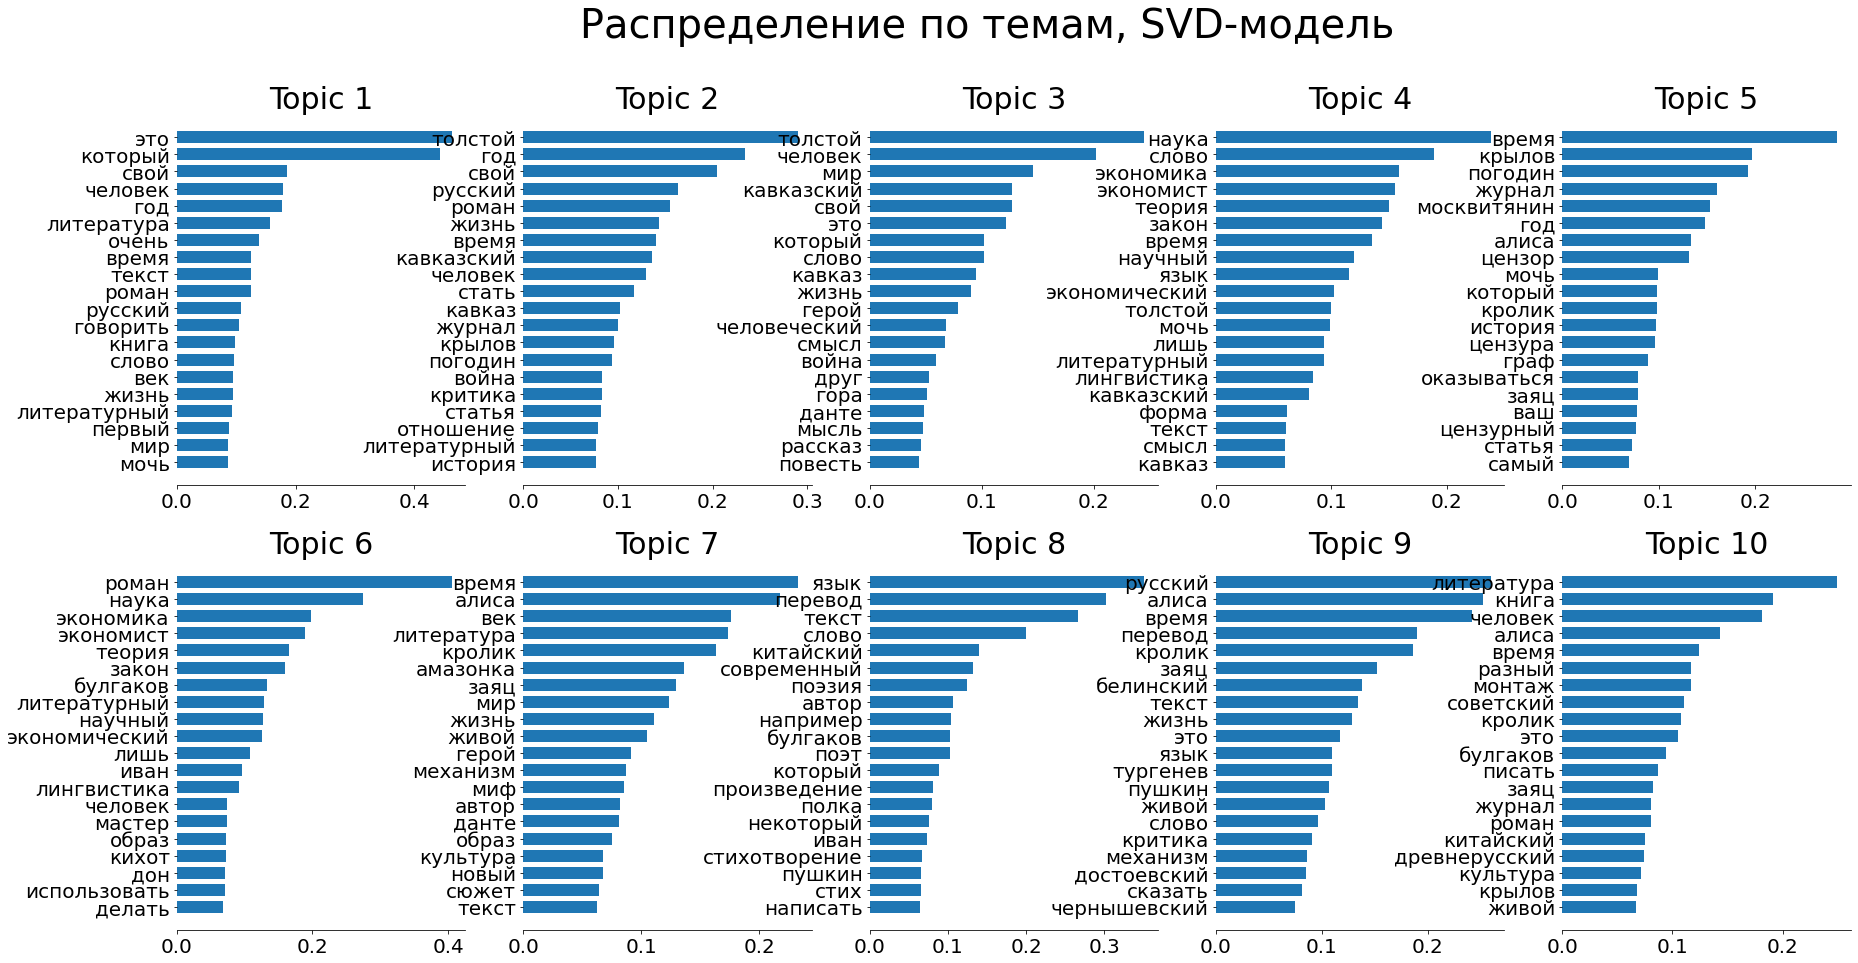

In [19]:
tf_feature_names = tf_vectorizer.get_feature_names()

plot_top_words(lsa_model, tf_feature_names, n_top_words, 'Распределение по темам, SVD-модель')

In [20]:
# для NMF понадобится tf-idf-векторизация, тк tf-idf не бывает негативным

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data)

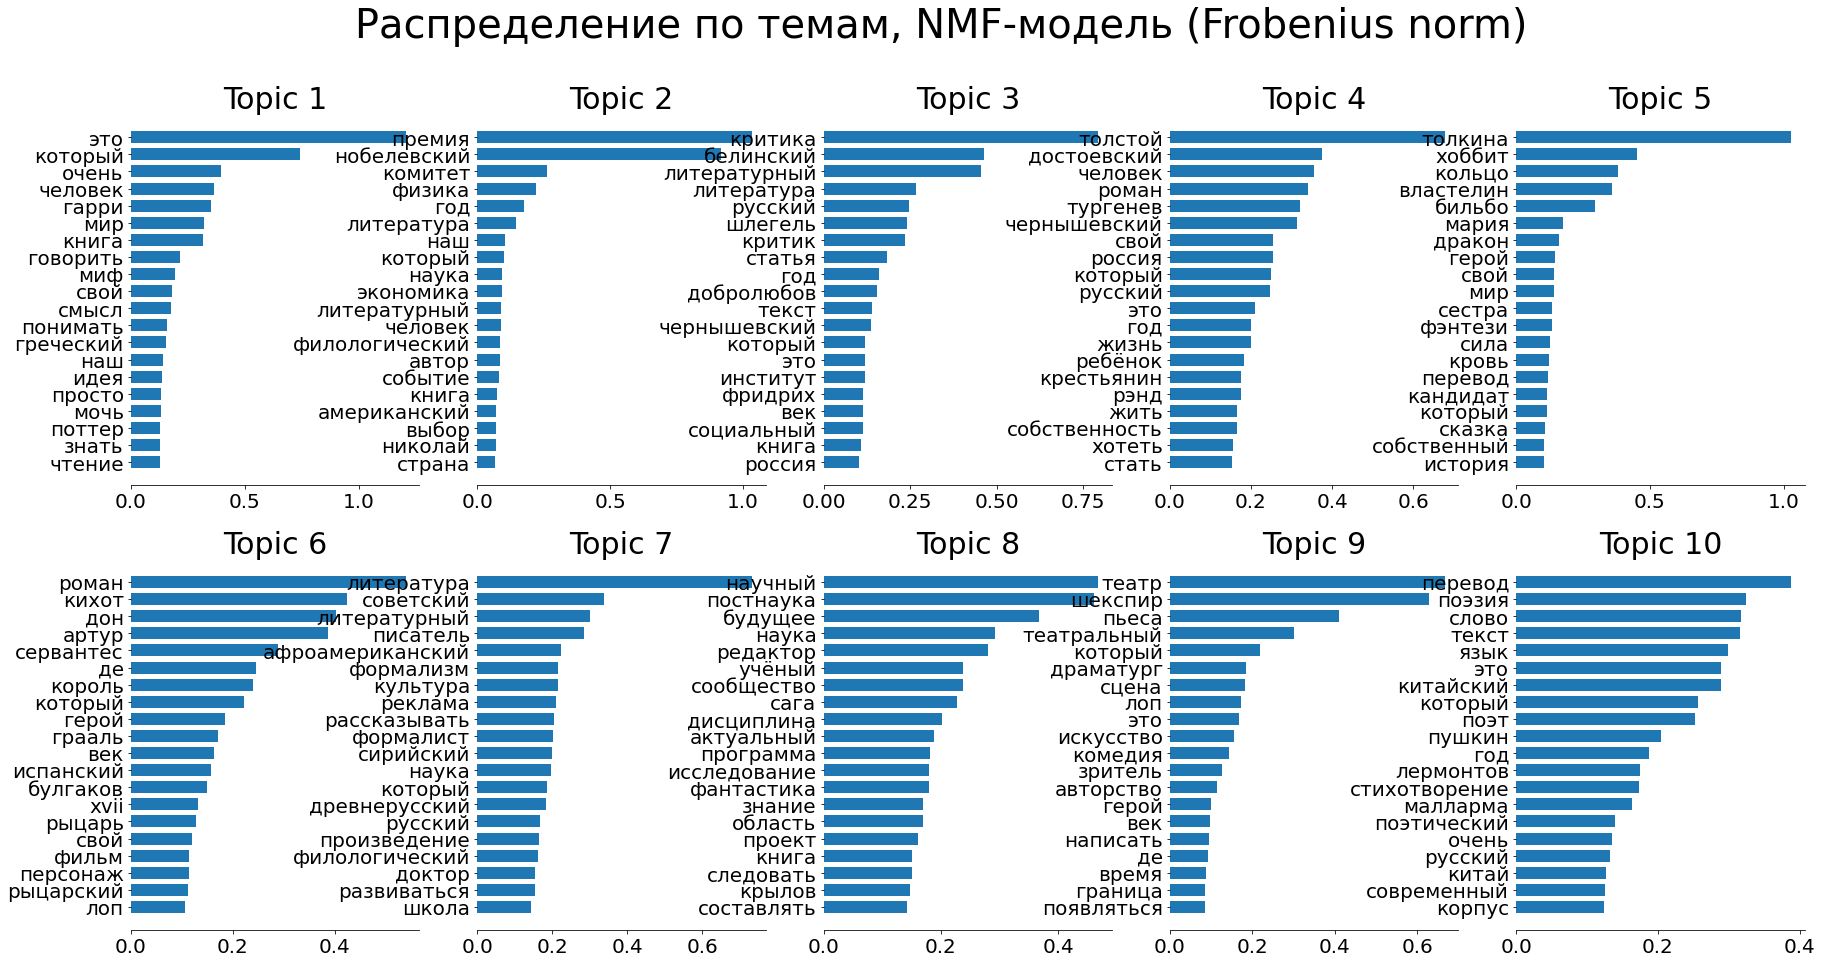

In [21]:
nmf = NMF(n_components=n_components).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Распределение по темам, NMF-модель (Frobenius norm)')

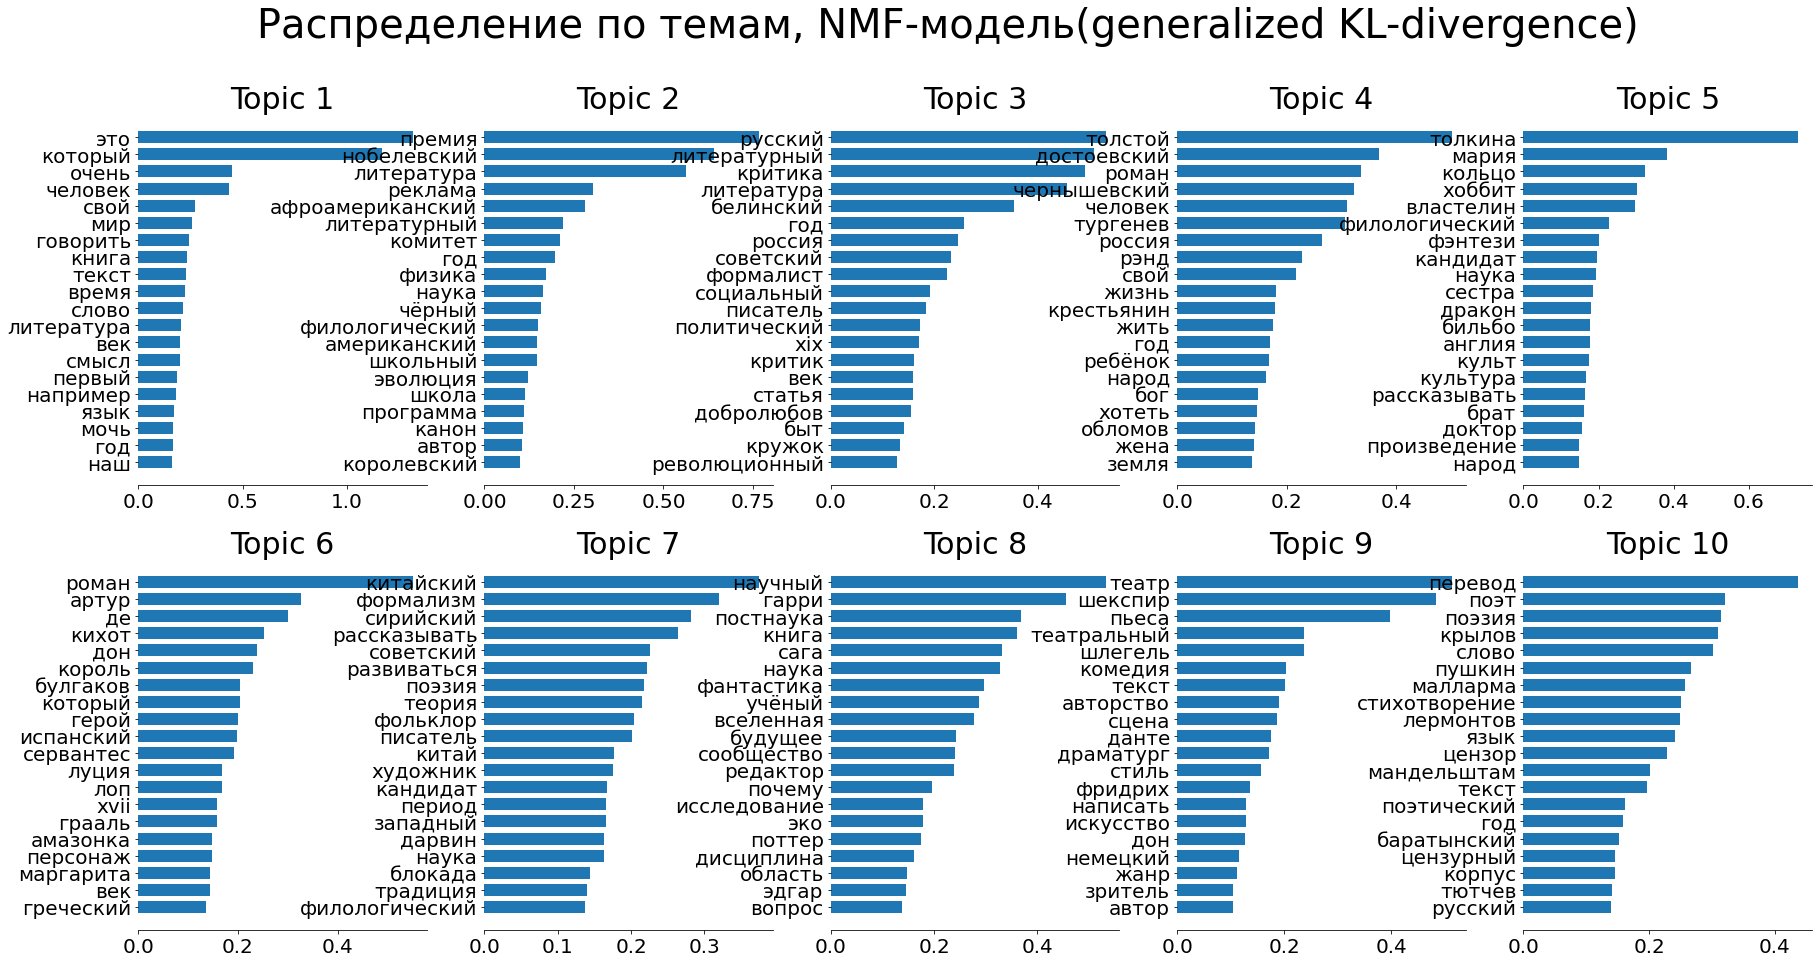

In [22]:
nmf = NMF(n_components=n_components, beta_loss='kullback-leibler', solver='mu').fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Распределение по темам, NMF-модель(generalized KL-divergence)')